# SPKIR CG data deep dive 1.7

In this notebook we display OOI SPKIR data stored in the kdata drive for certain deployments that may need additional annotations. Ref Des: GA01SUMO-SBD11-05-SPKIRB000

In [25]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm

from ooi_data_explorations.common import list_methods, list_streams, get_annotations, add_annotation_qc_flags, load_kdata, get_vocabulary, update_dataset
from ooi_data_explorations.uncabled.process_spkir import spkir_datalogger
from ooi_data_explorations.uncabled.process_metbk import metbk_datalogger
from ooinet.M2M import get_deployments
from qartod_testing.data_deep_dive import nanfill_time_gaps, compare_spkir_to_ctdbp

In [2]:
# Set parameters for data request 
refdes = 'GA01SUMO-SBD11-05-SPKIRB000'
site, node, sensor = refdes.split('-', 2)

In [3]:
# Set parameter for SPKIR internal temperature comparison with co-located CTDBP sea water temperature
ctdbp_node = 'RID16'
ctdbp_sensor = '03-CTDBPF000'

### Check data delivery methods, deployments, and annotations

In [4]:
# Create dict of methods and associated data streams
methods = list_methods(site, node, sensor)

streams = {}
for method in methods:
    streams[method] = list_streams(site, node, sensor, method)

streams

{'recovered_host': ['spkir_abj_dcl_instrument_recovered'],
 'telemetered': ['spkir_abj_dcl_instrument']}

In [5]:
# View deployment information
deployments = get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-SPKIRB-00229,2392,-42.92283,-42.4393,-6.0,2015-03-15 21:25:00,2015-11-26 10:08:00,AT26-30,NBP1510
1,2,CGINS-SPKIRB-00238,2425,-42.9246,-42.58668,-6.0,2015-11-14 21:06:00,2016-11-08 10:10:00,NBP1510,NBP1609
2,3,CGINS-SPKIRB-00229,2392,-42.9204,-42.440932,-6.0,2016-10-27 01:47:00,2018-01-14 10:24:00,NBP1609,AT39-03


In [6]:
## View annotations
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)

if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

annotations
# annotations['annotation'][5]

# Note: now I have moved the lines that add a human-readable date time up here where the annotations are displayed, however I'm not sure if the begin and endDT columns still need 
# to exist. I would like to remove them because they are just taking up space and don't add anything to the dataFrame displayed below.

,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
0,385,GA01SUMO,SBD11,None,None,None,1477532820000,1515925440000,"Deployment 3: Upon recovery, the bottom of the...",False,lgarzio@marine.rutgers.edu,None,[],2016-10-27T01:47:00,2018-01-14T10:24:00
1,653,GA01SUMO,None,None,None,None,1426454700000,1448532480000,Deployment 1: Buoy log files showed that seawa...,False,lgarzio@marine.rutgers.edu,None,[],2015-03-15T21:25:00,2015-11-26T10:08:00
2,654,GA01SUMO,SBD11,None,None,None,1426454700000,1448532480000,"Deployment 1: Upon recovery, the bottom of the...",False,lgarzio@marine.rutgers.edu,None,[],2015-03-15T21:25:00,2015-11-26T10:08:00
3,663,GA01SUMO,SBD11,None,None,None,1447535160000,1478599800000,"Deployment 2: Upon recovery, the bottom of the...",False,lgarzio@marine.rutgers.edu,None,[],2015-11-14T21:06:00,2016-11-08T10:10:00


In [29]:
annotations['annotation'][2]

'Deployment 1: Upon recovery, the bottom of the buoy was heavily biofouled with gooseneck barnacles. The barnacle coverage likely caused imporper sea water flushing at the location of the intakes and sensor faces for the subsurface instruments.'

### Deployment 1

For the temperature comparison, the data is there, but it's very different. So maybe this confirms that an annotation is needed. Was this SPKIR deployed in air?

Ha. It was deployed in air, at 6 m above sea level. Which instrument has air temperature? METBK, and METBK B has the early 2015 air temperature.

I also plotted the difference between the temperatures, so that I could see how that offset between them changes while the SPKIR temperature, drastically drops. 

We can clearly see how the gap between the two temperature time series closes after 19 Mar 2015. I think the tall spikes in the internal temperature sensor show the tendency for the instrument to heat up faster than the surrounding air. The last two days of data should maybe be flagged as suspect, but there was only about 5 days of data from this whole deployment so I would not be surprised if we choose to not use this deployment.

In [62]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 1

In [63]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


In [64]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [65]:
spkir = nanfill_time_gaps(spkir)

In [66]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 760, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2015-03-15T21:30:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 17.0 17.0 ... 17.0
    input_voltage                  (station, time) float32 8.4 8.4 ... nan 8.25
    deployment                     (station, time) float32 1.0 1.0 ... nan 1.0
    analog_rail_voltage            (station, time) float32 5.28 5.28 ... 5.28
    raw_irradiance_412             (station, time) float32 2.148e+09 ... 2.53...
    raw_irradiance_444             (station, time) float32 2.148e+09 ... 2.60...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.07238 ... 117.4
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... nan 0.0
    station_name                   (station) <U8 'GA01SUMO'
    lat                            (station) float32 -42.92
    lon                            (station) float32 -42.44
    z                              (station) float32 -5.0
Attributes: (12/69)
    node:                               SBD11
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            -5.0
    geospatial_vertical_max:            -5.0

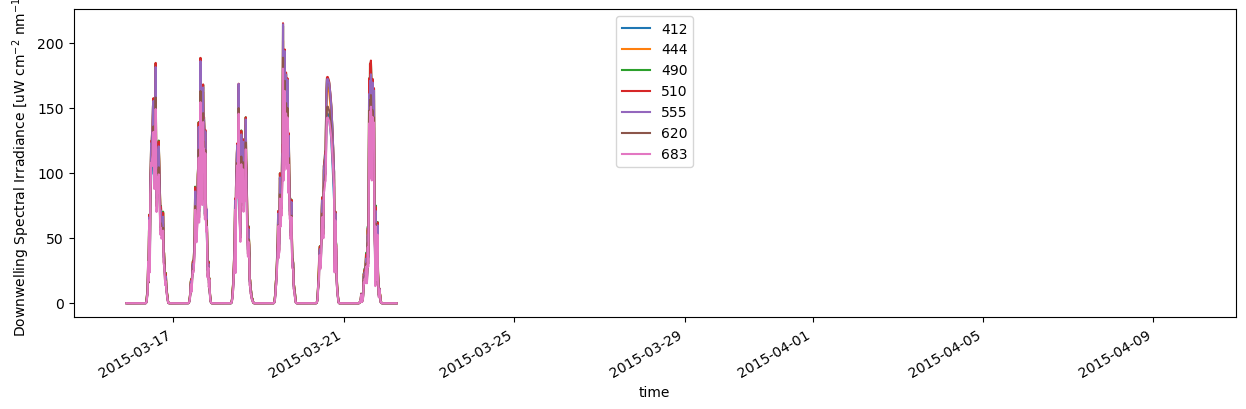

In [11]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

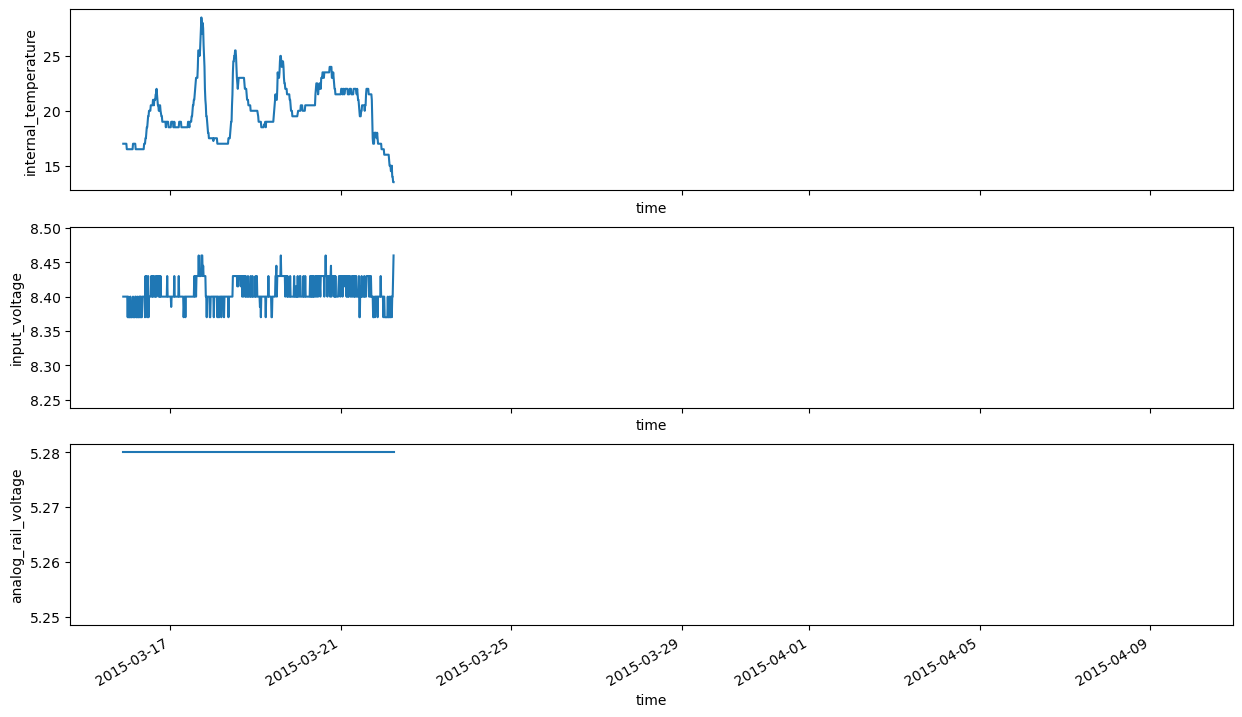

In [12]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


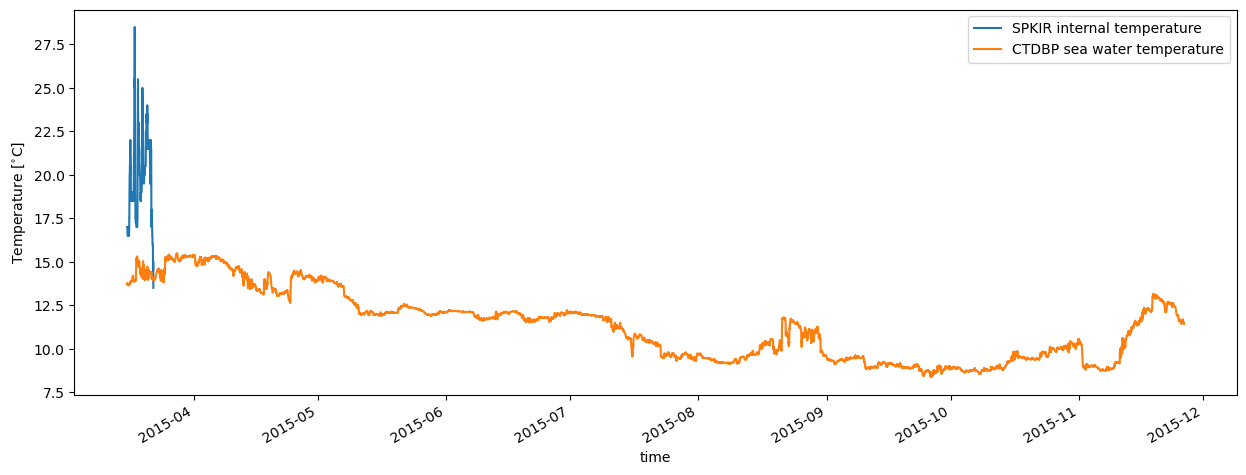

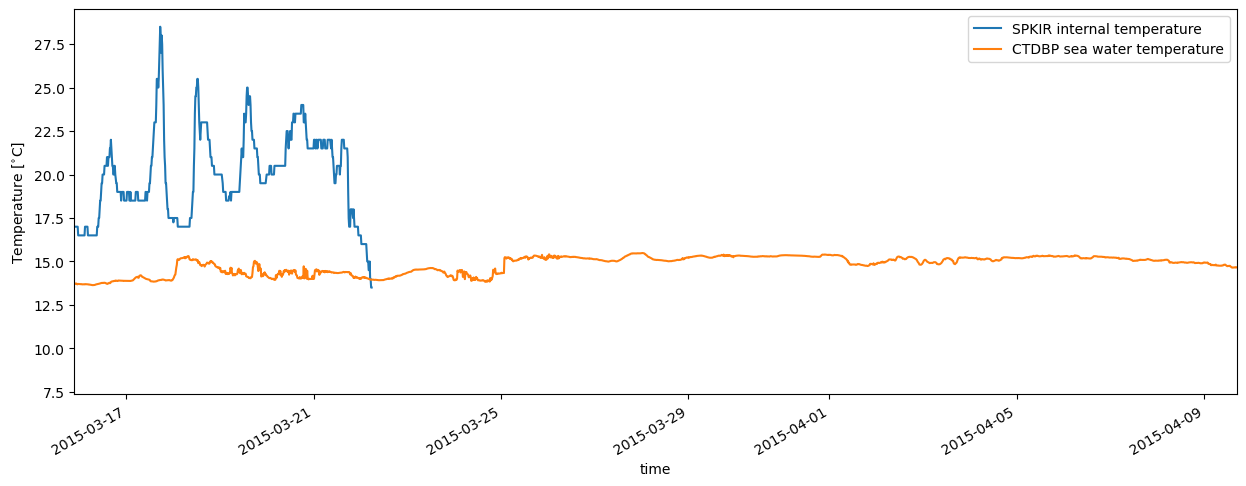

In [24]:
# Compare SPKIR internal temperature time series to sea water temperature
# to check that the instrument is performing as expected.
# The lower figure is has the xlim updated to only cover the time period
# in the SPKIR dataset. 
ctdbp, fig, ax = compare_spkir_to_ctdbp(spkir, site, deploy, ctdbp_node, ctdbp_sensor)
ax.set_xbound(lower=spkir['time'][0], upper=spkir['time'][-1])
fig

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


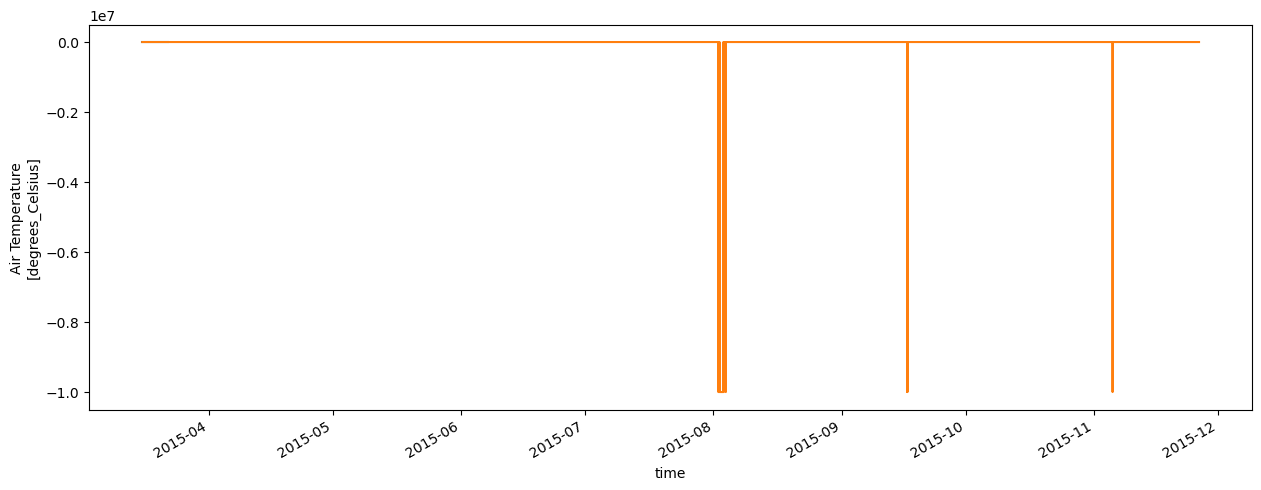

In [75]:
# Check METBK B air temperature, now that we know this SPKIR was deployed in air.
# Load METBK data
metbk_node = 'SBD12'
metbk_sensor = '06-METBKA000'
metbk_method = 'recovered_host'
metbk_stream = 'metbk_a_dcl_instrument_recovered'
metbk = load_kdata(site, metbk_node, metbk_sensor, metbk_method,
                    metbk_stream, ('*deployment%04d*METBK*.nc' % deploy))
metbk = metbk_datalogger(metbk)

# Create plot of SPKIR internal temperature and CTDBP temperature
fig, ax = plt.subplots(1,1, sharex=True, figsize=(15,5))
spkir['internal_temperature'][0].plot.line(ax=ax, label='SPKIR internal temperature')
metbk['air_temperature'].plot.line(ax=ax, label='METBK B air temperature')

In [76]:
# Overlay difference between the two temperature time series
diff1 = spkir['internal_temperature'][0].values 
diff2 = metbk['air_temperature'].sel(time=spkir['time'], method="nearest")
diff = diff1 - diff2[0:diff1.size]
diff

<xarray.DataArray 'air_temperature' (time: 760)>
array([ 4.283    ,  4.3879995,  4.3879995,  4.3809996,  4.4940004,
        4.4940004,  4.5389996,  4.5690002,  4.1070004,  4.1520004,
        4.212    ,  4.2580004,  4.212    ,  4.2650003,  4.2650003,
        4.273    ,  4.295    ,  4.243    ,  4.3030005,  4.25     ,
        4.2580004,  4.182    ,  4.6969995,  4.6899996,  4.66     ,
        4.6219997,  4.667    ,  4.743    ,  4.212    ,  4.2279997,
        4.3030005,  4.2650003,  4.333    ,  4.311    ,  4.401    ,
        4.326    ,  4.424    ,  4.356    ,  4.363    ,  4.484    ,
        4.446    ,  4.446    ,  4.3479996,  4.25     ,  4.212    ,
        4.273    ,  4.1969995,  4.7279997,  4.63     ,  4.5620003,
        4.9940004,  5.0010004,  5.366    ,  5.8430004,  5.873    ,
        6.3050003,  6.722    ,  6.8199997,  7.2      ,  7.1920004,
        7.1540003,  7.0790005,  7.4209995,  7.406    ,  7.217    ,
        7.3      ,  7.217    ,  7.7019997,  7.5810003,  7.021    ,
        7.446    ,  7.483    ,  7.5129995,  7.946    ,  7.84     ,
        8.302    ,  7.757    ,  7.2799997,  6.8170004,  6.863    ,
        6.2869997,  6.2419996,  6.682    ,  6.651    ,  6.174    ,
        5.932    ,  5.682    ,  5.7040005,  5.151    ,  5.1210003,
        5.1140003,  4.9779997,  4.9329996,  5.016    ,  4.986    ,
        4.9779997,  4.486    ,  4.9399996,  4.8719997,  4.8950005,
...
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,  4.436    ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,  6.696    ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-03-15T21:30:13.536000 ... 2015-04-09T...
Attributes:
    _FillValue:               -9999999.0
    comment:                  Air Temperature refers to the temperature of th...
    long_name:                Air Temperature
    precision:                3
    coordinates:              time lat lon
    data_product_identifier:  TEMPAIR_L1
    standard_name:            air_temperature
    units:                    degrees_Celsius

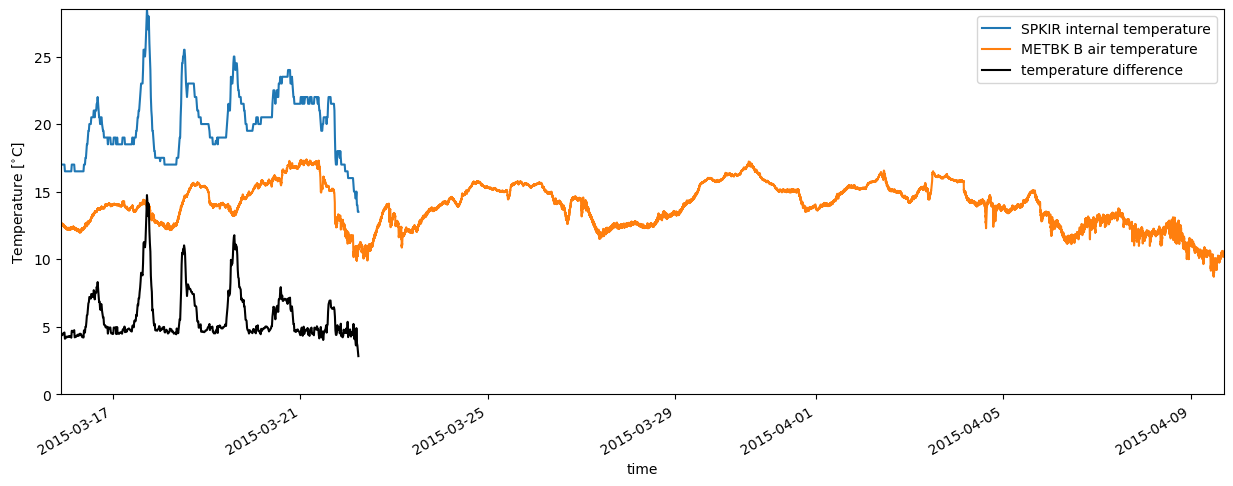

In [77]:
# Set plot properties
diff.plot.line(ax=ax, color='black', label='temperature difference')
ax.set_ylabel(
    'Temperature [$^{\circ}$C]')
ax.legend()
ax.set_xbound(lower=spkir['time'][0], upper=spkir['time'][-1])
ax.set_ybound(lower=0, upper=spkir['internal_temperature'].max())
fig

### Deployment 3

I am now plotting the internal temperature with METBK B air temperature now that I know this SPKIR is in the air. The air temperature is much closer to the SPKIR internal temperature, but I don't see the same spikes that are in the SPKIR internal temperature. I would still mark those as suspect.

The SPKIR can overheat... but I think that is at some unreasonable temperature. I guess this speaks to its ability to heat much faster than the ambient air while above water in direct sunlight. Since the internal temperature quickly returns to a temperature closer to the METBK air temperature and these temperature spikes seem brief, I don't think they clearly indicate that the few concurrent irradiance data points should be considered suspect. I would not add an annotation for those points. 

We might still want to manually ignore the few points that are in the middle of larger gaps though.

In [32]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 3

In [33]:
# load annotations and data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


In [34]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [35]:
spkir = nanfill_time_gaps(spkir)

In [36]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 40195, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2016-10-27T01:45:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 15.5 14.5 ... 19.5
    input_voltage                  (station, time) float32 8.37 8.4 ... 8.46
    deployment                     (station, time) float32 3.0 3.0 ... 3.0 3.0
    analog_rail_voltage            (station, time) float32 5.28 5.28 ... 5.28
    raw_irradiance_412             (station, time) float32 2.147e+09 ... 2.33...
    raw_irradiance_444             (station, time) float32 2.148e+09 ... 2.35...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.008643 ... 54.34
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'GA01SUMO'
    lat                            (station) float32 -42.92
    lon                            (station) float32 -42.44
    z                              (station) float32 -5.0
Attributes: (12/69)
    node:                               SBD11
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            -5.0
    geospatial_vertical_max:            -5.0

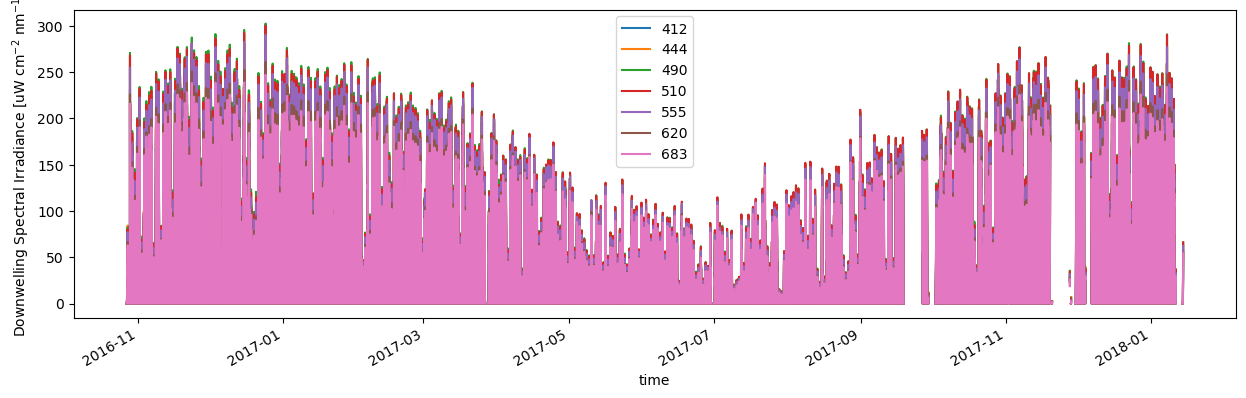

In [25]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

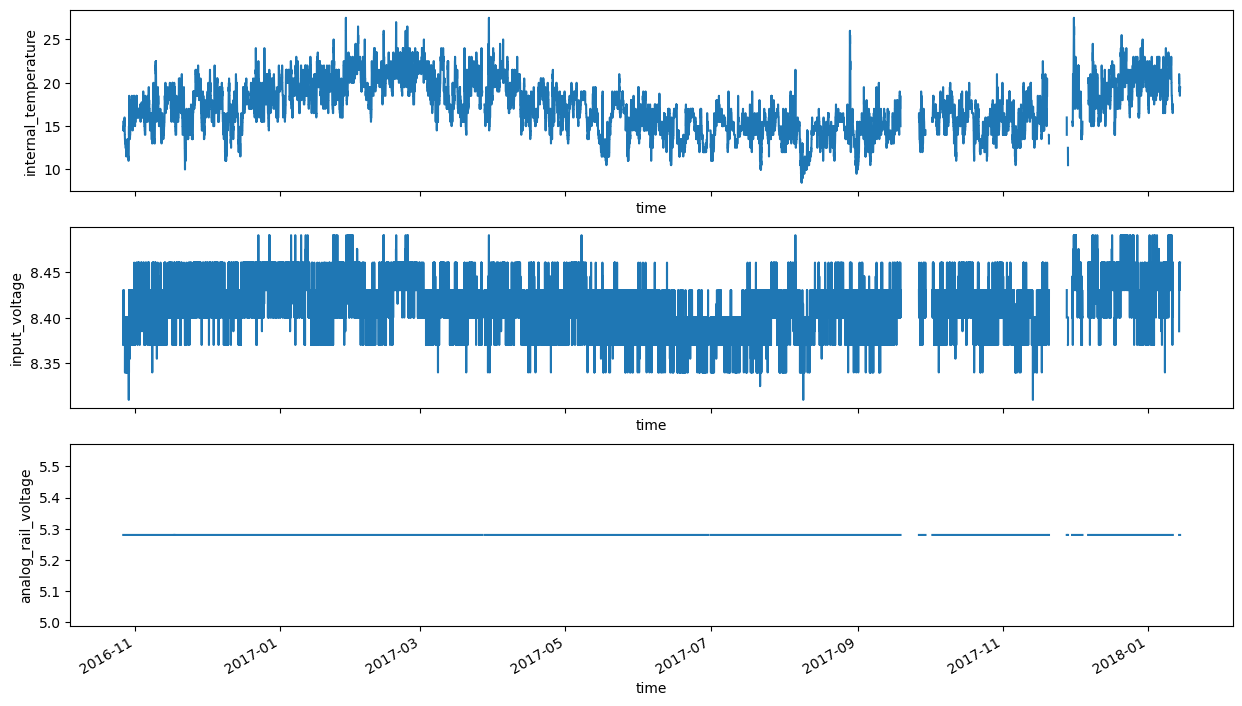

In [26]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


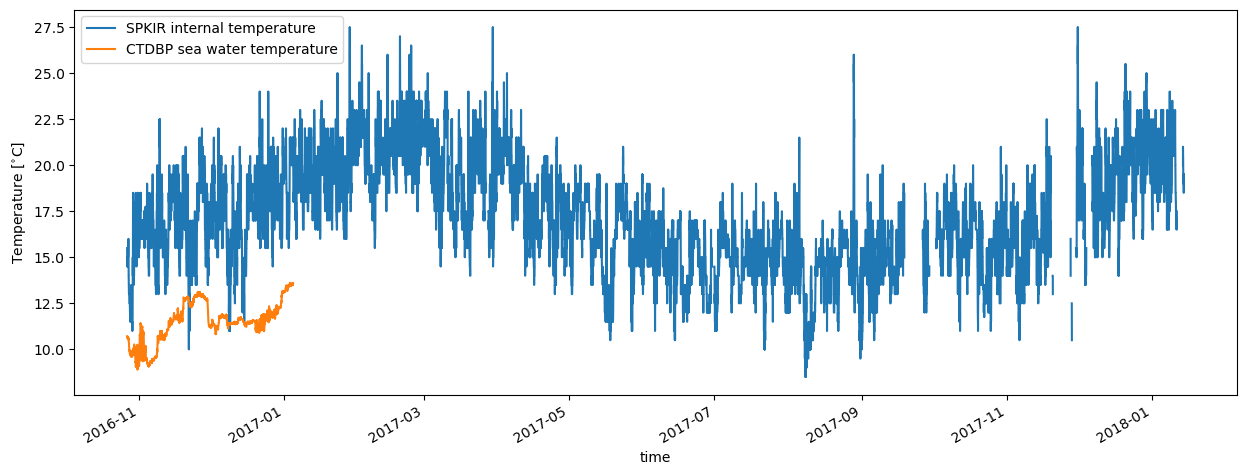

In [19]:
# Compare SPKIR internal temperature time series to sea water temperature
# to check that the instrument is performing as expected
ctdbp, fig, ax = compare_spkir_to_ctdbp(spkir, site, deploy, ctdbp_node, ctdbp_sensor)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


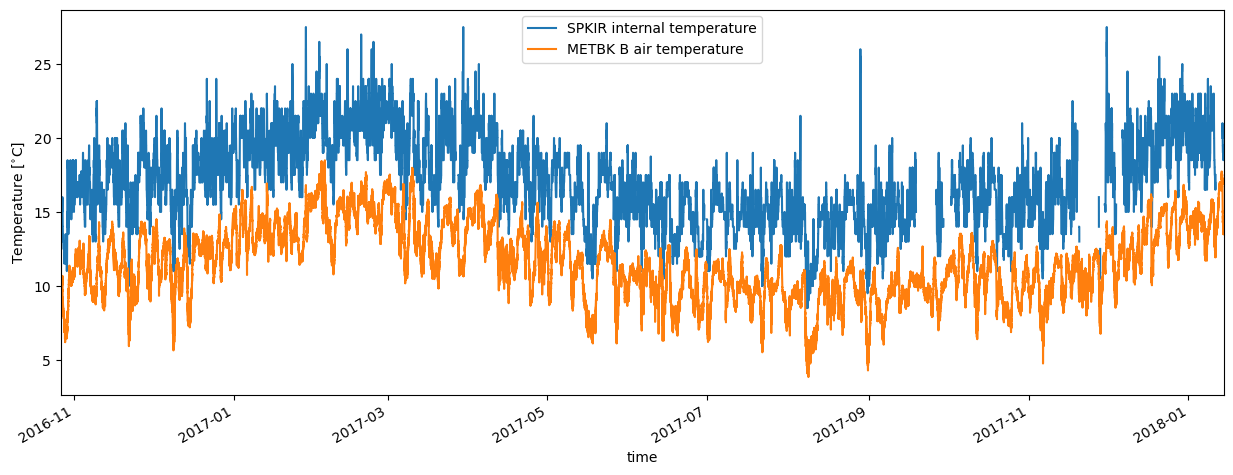

In [37]:
# Check METBK B air temperature, now that we know this SPKIR was deployed in air.
# Load METBK data
metbk_node = 'SBD12'
metbk_sensor = '06-METBKA000'
metbk_method = 'recovered_host'
metbk_stream = 'metbk_a_dcl_instrument_recovered'
metbk = load_kdata(site, metbk_node, metbk_sensor, metbk_method,
                    metbk_stream, ('*deployment%04d*METBK*.nc' % deploy))
metbk = metbk_datalogger(metbk)

# Create plot of SPKIR internal temperature and CTDBP temperature
fig, ax = plt.subplots(1,1, sharex=True, figsize=(15,5))
spkir['internal_temperature'][0].plot.line(ax=ax, label='SPKIR internal temperature')
metbk['air_temperature'].plot.line(ax=ax, label='METBK B air temperature')
ax.set_ylabel(
    'Temperature [$^{\circ}$C]')
ax.legend()
ax.set_xbound(lower=spkir['time'][0], upper=spkir['time'][-1])
# ax.set_ybound(lower=0, upper=spkir['internal_temperature'].max())
plt.show()

### Histograms of downwelling irradiance measurements

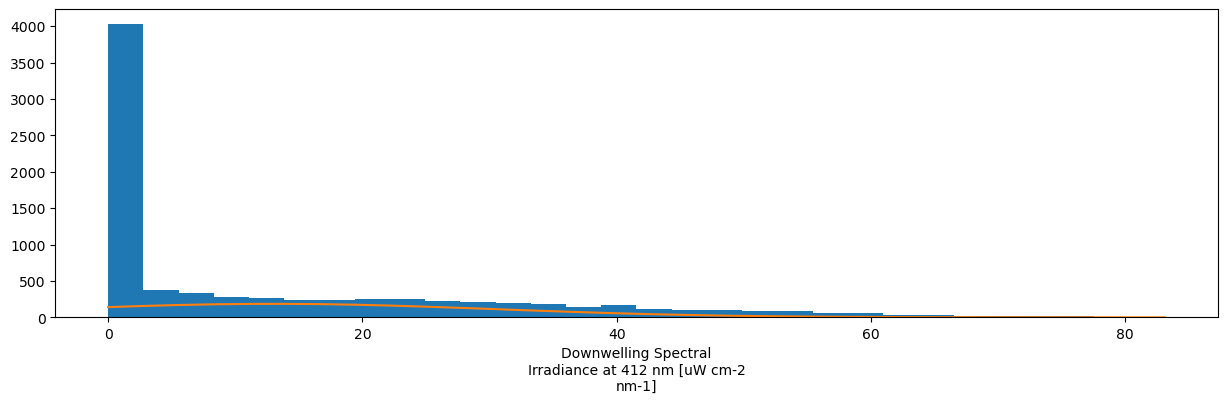

In [30]:
# histogram of downwelling irradiance @ 412 nm variable
irrad412 = spkir['downwelling_irradiance_412'][0]
# irrad412 = spkir['downwelling_irradiance_412'][0].sel(time=slice('2017-07-01'))
mu412 = irrad412.mean()
sig412 = irrad412.std()

plt.figure(figsize=(15,4))
c, x, h = irrad412.plot.hist(bins=30)
norm412 = sum(c)*norm.pdf(x, mu412, sig412)
plt.plot(x, norm412)

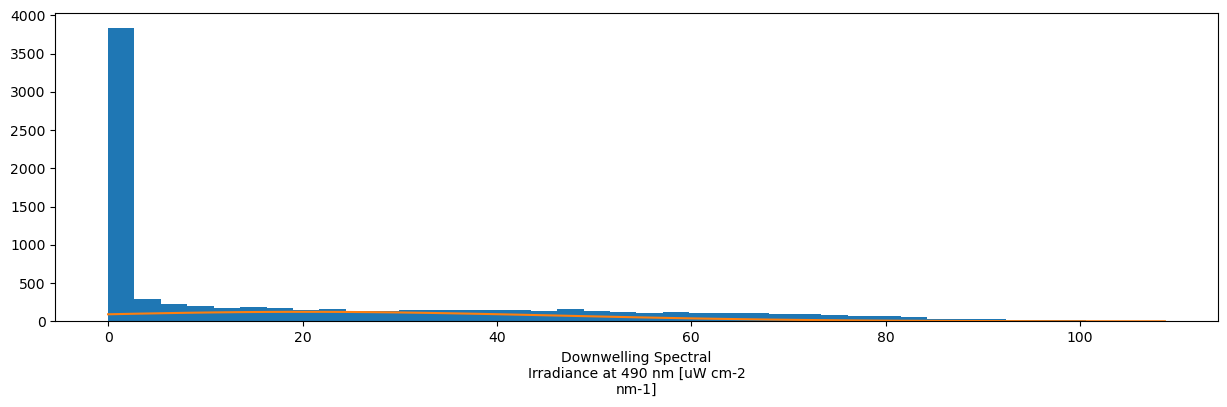

In [31]:
# histogram of downwelling irradiance @ 490 nm variable
irrad490 = spkir['downwelling_irradiance_490'][0]
# irrad490 = spkir['downwelling_irradiance_490'][0].sel(time=slice('2017-07-01'))
mu490 = irrad490.mean()
sig490 = irrad490.std()

plt.figure(figsize=(15,4))
c, x, h = irrad490.plot.hist(bins=40)
norm490 = sum(c)*norm.pdf(x, mu490, sig490)
plt.plot(x, norm490)

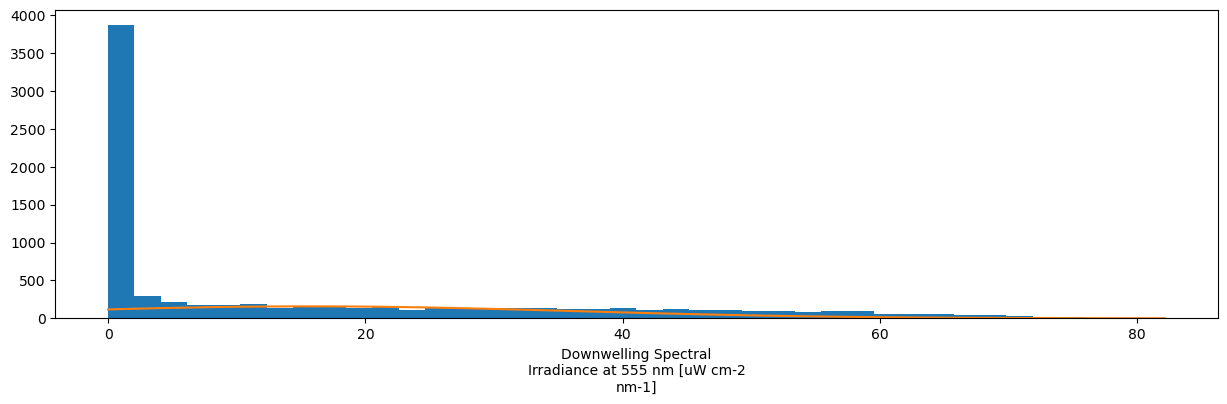

In [32]:
# histogram of downwelling irradiance @ 555 nm variable
irrad555 = spkir['downwelling_irradiance_555'][0]
# irrad555 = spkir['downwelling_irradiance_555'][0].sel(time=slice('2015-06-01'))
mu555 = irrad555.mean()
sig555 = irrad555.std()

plt.figure(figsize=(15,4))
c, x, h = irrad555.plot.hist(bins=40)
norm555 = sum(c)*norm.pdf(x, mu555, sig555)
plt.plot(x, norm555)

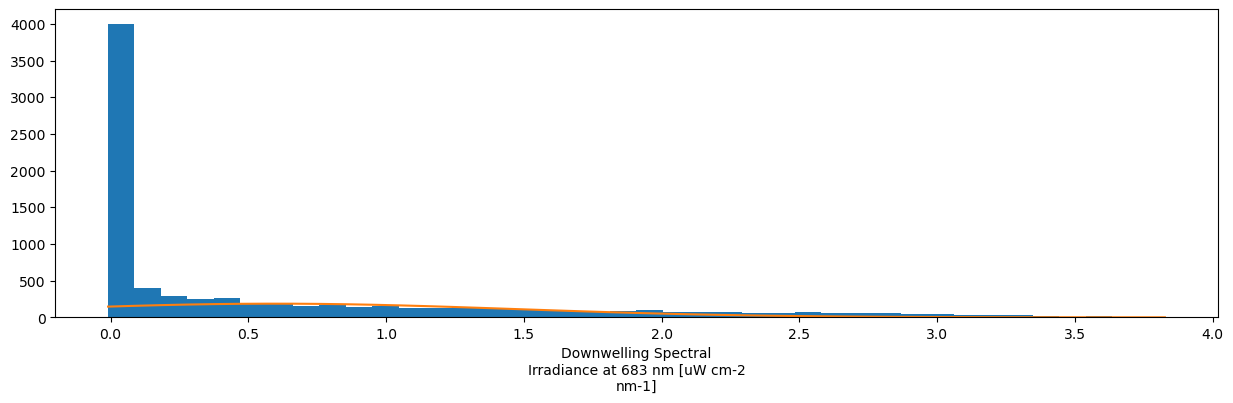

In [33]:
# histogram of downwelling irradiance @ 683 nm variable
irrad683 = spkir['downwelling_irradiance_683'][0]
# irrad683 = spkir['downwelling_irradiance_683'][0].sel(time=slice('2017-07-01'))
mu683 = irrad683.mean()
sig683 = irrad683.std()

plt.figure(figsize=(15,4))
c, x, h = irrad683.plot.hist(bins=40)
norm683 = 0.05*sum(c)*norm.pdf(x, mu683, sig683)
plt.plot(x, norm683)

In [34]:
# concat the different irradiance variables for histogram of all irradiance values
irradAll = xr.DataArray()
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        irradAll = xr.concat([irradAll, spkir[var][0]], dim='channel')
irradAll

<xarray.DataArray (channel: 8, time: 8581)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-1.24489265e-02, -1.22679379e-02, -1.27385072e-02, ...,
         3.33838081e+01,  2.91790657e+01,  2.71376114e+01],
       [-2.28602290e-02, -2.30053701e-02, -2.28148736e-02, ...,
         4.15520287e+01,  3.64205742e+01,  3.37744560e+01],
       ...,
       [-8.62311665e-03, -7.81955104e-03, -8.97590257e-03, ...,
         3.88252945e+01,  3.34404564e+01,  3.07892475e+01],
       [ 1.19705470e-02,  1.19244633e-02,  1.15373600e-02, ...,
         4.89614058e+00,  4.12962008e+00,  3.72692156e+00],
       [-4.96644620e-03, -5.32475766e-03, -4.51855734e-03, ...,
         1.25258076e+00,  1.05488253e+00,  9.43447709e-01]])
Coordinates:
  * time     (time) datetime64[ns] 2015-05-09T01:00:00 ... 2015-09-28T19:45:00
Dimensions without coordinates: channel

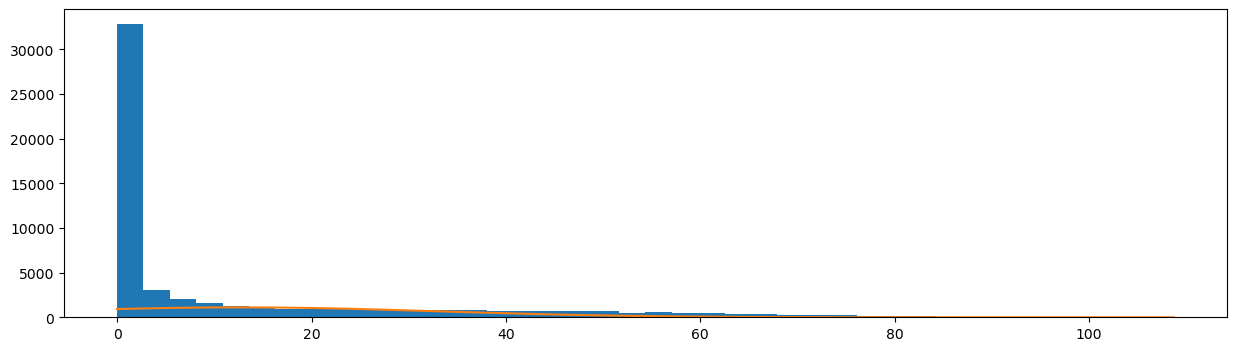

In [35]:
# histogram using all irradiance values
radAll= irradAll
muAll = radAll.mean()
sigAll = radAll.std()

plt.figure(figsize=(15,4))
c, x, h = radAll.plot.hist(bins=40)
normAll = sum(c)*norm.pdf(x, muAll, sigAll)
plt.plot(x, normAll)

### Histograms after monthly mean filter

### Spectrograms of downwelling irradiance (not burst averaged)

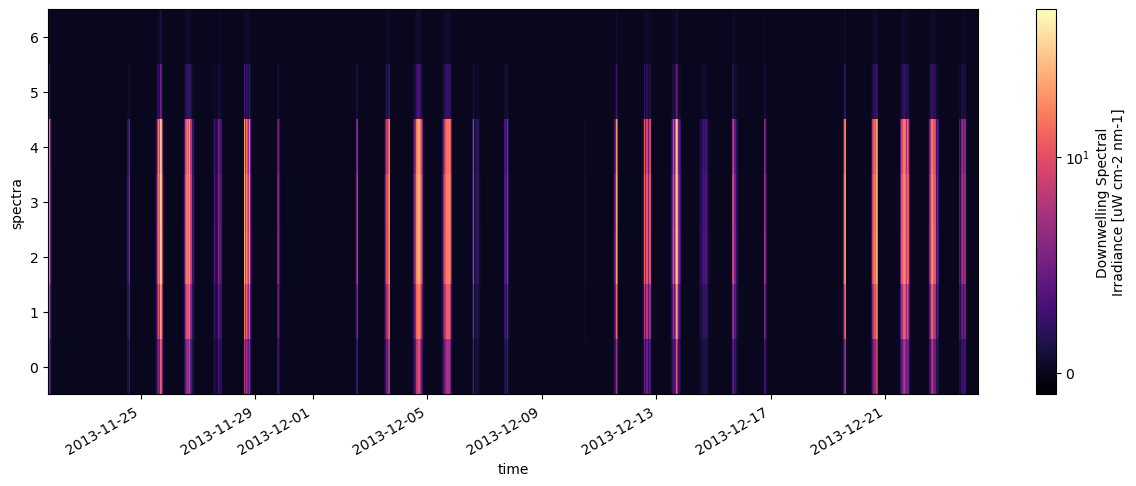

In [20]:
# Trying same plot with full resolution data with log-scale colormap (linear between -1,10)
xr.plot.pcolormesh(spkir_full_time.spkir_abj_cspp_downwelling_vector, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [28]:
# That was a bad idea so let's resample to daily
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="1D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 174, spectra: 7)>
array([[ 9.71255556e+00,  1.33028855e+01,  1.93817753e+01, ...,
         2.23164523e+01,  3.62021577e+00,  7.82912088e-01],
       [ 6.20054185e-01,  9.06080839e-01,  1.34600973e+00, ...,
         1.25914219e+00,  1.82409459e-01,  5.95385999e-02],
       [ 1.73746901e-01,  2.63608506e-01,  3.78101900e-01, ...,
         4.27118953e-01,  6.74665225e-02,  3.25888514e-02],
       ...,
       [ 7.39844170e-02,  7.86333704e-02,  8.35438973e-02, ...,
         5.61443408e-02,  8.31668786e-03,  4.77597635e-03],
       [ 2.28589437e-01,  2.76852485e-01,  3.28657073e-01, ...,
         2.09412793e-01,  2.62619446e-02,  1.17360818e-02],
       [ 2.29803754e-03,  3.92295552e-04, -2.80754229e-04, ...,
        -6.79578805e-04,  1.25565920e-03,  3.28846042e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-07 ... 2019-09-26
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

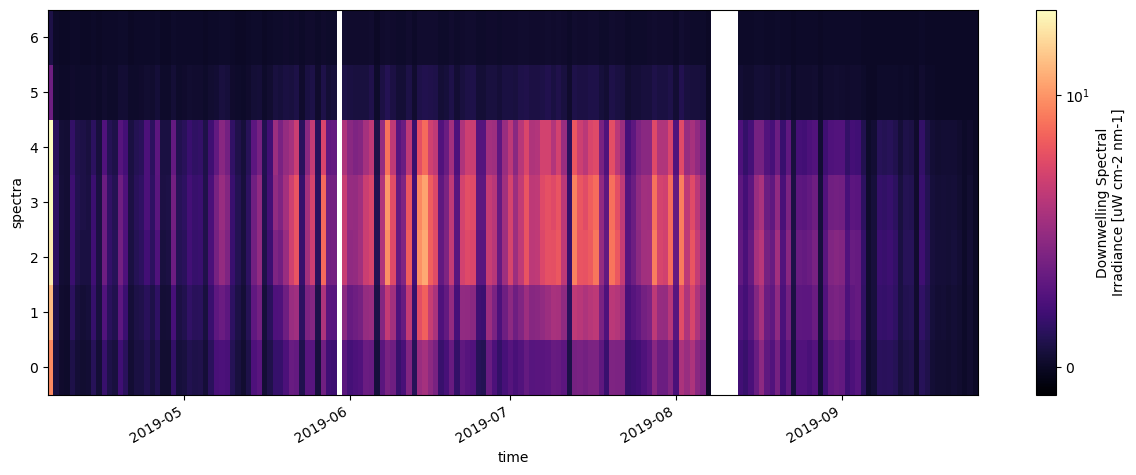

In [30]:
# pcolormesh plot with log-scale cmap except for [-1, 10] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [31]:
# Now lets try this with a 5-day median resample
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="5D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 35, spectra: 7)>
array([[6.82127204e-01, 9.39339140e-01, 1.49556243e+00, 1.66573864e+00,
        1.50775647e+00, 2.17019475e-01, 6.62599682e-02],
       [4.09351526e-01, 5.97971766e-01, 8.23282033e-01, 8.41685295e-01,
        7.24953008e-01, 1.07756459e-01, 4.46083474e-02],
       [1.11149060e+00, 1.63481436e+00, 2.06272259e+00, 1.99825457e+00,
        1.42778278e+00, 2.07900504e-01, 6.89136231e-02],
       [6.33905790e-01, 8.30168475e-01, 1.26737414e+00, 1.37036116e+00,
        1.22211412e+00, 1.81988724e-01, 5.88591173e-02],
       [4.88950510e-01, 7.05335209e-01, 1.08804481e+00, 1.18094031e+00,
        1.09429885e+00, 1.71634988e-01, 5.71144999e-02],
       [6.95715056e-01, 9.77443677e-01, 1.34453113e+00, 1.40168619e+00,
        1.25158622e+00, 1.94583331e-01, 6.10077514e-02],
       [1.77887788e+00, 2.40299210e+00, 3.25211386e+00, 3.32345650e+00,
        2.82799702e+00, 3.63398624e-01, 9.33474496e-02],
       [8.35149703e-01, 1.11870379e+00, 1.48298037e+00, 1.51192503e+00,
        1.28393037e+00, 1.92699171e-01, 5.95294177e-02],
       [1.19328147e+00, 1.70288643e+00, 2.52271664e+00, 2.78847411e+00,
        2.70395010e+00, 3.80136554e-01, 1.00454470e-01],
       [2.62830054e+00, 3.91435216e+00, 5.20132994e+00, 5.24724249e+00,
        4.42306642e+00, 5.73875815e-01, 1.45943075e-01],
...
       [2.06008457e+00, 2.58632186e+00, 3.16383481e+00, 2.98038643e+00,
        2.42941038e+00, 3.60160794e-01, 9.68550489e-02],
       [2.74753531e+00, 3.09858421e+00, 3.49182410e+00, 3.13586101e+00,
        2.39268108e+00, 3.07221372e-01, 8.25675502e-02],
       [2.20276612e+00, 2.58443371e+00, 2.88604360e+00, 2.58521177e+00,
        1.98243281e+00, 2.43159916e-01, 6.05670060e-02],
       [1.66826512e+00, 2.02154214e+00, 2.23259445e+00, 1.97611683e+00,
        1.40635816e+00, 1.69531314e-01, 4.33503864e-02],
       [2.70608963e+00, 3.34031155e+00, 3.58219552e+00, 3.11022829e+00,
        2.22732694e+00, 2.56595992e-01, 6.27982799e-02],
       [7.45937359e-01, 8.52196817e-01, 9.00792402e-01, 7.83724039e-01,
        6.10910023e-01, 8.67380087e-02, 2.31770994e-02],
       [1.05503826e+00, 1.35776975e+00, 1.46589740e+00, 1.28284831e+00,
        9.28877248e-01, 1.16683356e-01, 3.63260056e-02],
       [7.11412936e-01, 9.11214792e-01, 1.05646410e+00, 9.39103459e-01,
        7.16780233e-01, 8.74880143e-02, 2.91914385e-02],
       [3.15291575e-01, 3.98664721e-01, 4.91061523e-01, 4.47583359e-01,
        3.45641780e-01, 4.67864891e-02, 1.80901622e-02],
       [6.95465087e-03, 5.62515071e-03, 3.77377740e-03, 2.68314116e-03,
        3.17550394e-03, 3.19469816e-03, 4.37195968e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-11 ... 2019-09-23
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

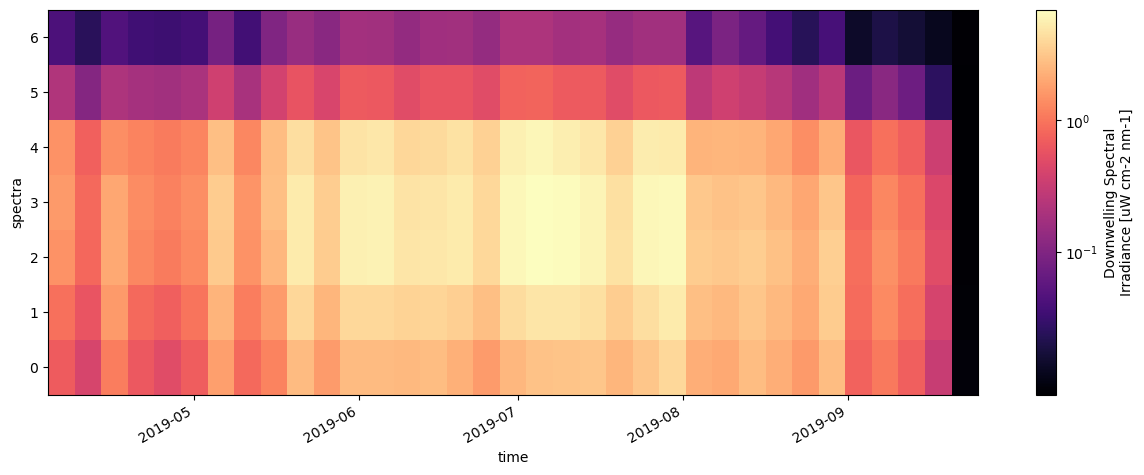

In [37]:
# 5-day median of downwelling spectral irradiance pcolormesh plot with log-scale cmap except for [0, 0.01] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=0.1))